In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import torch
import cv2
import sys
import json
from PIL import Image
from tqdm import tqdm
import multiprocessing as mp
import pydensecrf.utils as utils
import pydensecrf.densecrf as dcrf

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

from src.dataset import *
from src.models import *

# %matplotlib inline
%config InlineBackend.figure_format = 'retina'
print(f"Pytorch Version:[{torch.__version__}]")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device:[{device}]")

Number of super categories: 11
Number of categories: 11
Number of annotations: 21116
Number of images: 2617
Pytorch Version:[1.7.1]
device:[cuda:0]


In [2]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_norm = transforms.Normalize(
    mean = [-m / s for m, s in zip(mean, std)],
    std = [1 / s for s in std]
)

In [3]:
class Cfg:
    batch_size = 4
    saved_dir = "./saved_model/exp1"
    file_name = "deeplabv3p.pt"
    submission_dir = "./submission"
    submission_name = "deeplabv3.csv"

In [4]:
COLORS =[
        [129, 236, 236],
        [2, 132, 227],
        [232, 67, 147],
        [255, 234, 267],
        [0, 184, 148],
        [85, 239, 196],
        [48, 51, 107],
        [255, 159, 26],
        [255, 204, 204],
        [179, 57, 57],
        [248, 243, 212],
    ]

COLORS = np.vstack([[0, 0, 0], COLORS]).astype('uint8')  # (12, 3)으로 쌓아줌

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))


test_path = dataset_path + '/test.json'

test_transform = A.Compose([
                A.Resize(256, 256),
                ToTensorV2()
                ])


# test dataset
test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

print(test_dataset[0])

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=Cfg.batch_size,
                                        num_workers=4,
                                        collate_fn=collate_fn)

loading annotations into memory...
Done (t=20.03s)
creating index...
index created!
(tensor([[[ 82,  79,  84,  ...,  29,  28,  28],
         [ 57,  56,  58,  ...,  28,  27,  26],
         [ 39,  41,  42,  ...,  28,  28,  28],
         ...,
         [ 65,  66,  64,  ...,  68,  64,  55],
         [ 64,  59,  57,  ..., 112, 110,  61],
         [ 59,  58,  56,  ..., 158, 132,  69]],

        [[ 79,  76,  81,  ...,  21,  20,  20],
         [ 54,  53,  55,  ...,  20,  19,  18],
         [ 36,  38,  39,  ...,  20,  20,  20],
         ...,
         [ 49,  50,  49,  ...,  57,  54,  46],
         [ 46,  41,  41,  ..., 100,  99,  50],
         [ 41,  40,  38,  ..., 145, 120,  57]],

        [[ 70,  67,  72,  ...,  19,  18,  18],
         [ 45,  44,  46,  ...,  18,  17,  16],
         [ 27,  29,  32,  ...,  18,  18,  18],
         ...,
         [ 36,  37,  36,  ...,  40,  43,  41],
         [ 34,  29,  28,  ...,  74,  81,  41],
         [ 27,  26,  24,  ..., 112,  95,  43]]], dtype=torch.uint8), {

((tensor([[[ 82,  79,  84,  ...,  29,  28,  28],
           [ 57,  56,  58,  ...,  28,  27,  26],
           [ 39,  41,  42,  ...,  28,  28,  28],
           ...,
           [ 65,  66,  64,  ...,  68,  64,  55],
           [ 64,  59,  57,  ..., 112, 110,  61],
           [ 59,  58,  56,  ..., 158, 132,  69]],
  
          [[ 79,  76,  81,  ...,  21,  20,  20],
           [ 54,  53,  55,  ...,  20,  19,  18],
           [ 36,  38,  39,  ...,  20,  20,  20],
           ...,
           [ 49,  50,  49,  ...,  57,  54,  46],
           [ 46,  41,  41,  ..., 100,  99,  50],
           [ 41,  40,  38,  ..., 145, 120,  57]],
  
          [[ 70,  67,  72,  ...,  19,  18,  18],
           [ 45,  44,  46,  ...,  18,  17,  16],
           [ 27,  29,  32,  ...,  18,  18,  18],
           ...,
           [ 36,  37,  36,  ...,  40,  43,  41],
           [ 34,  29,  28,  ...,  74,  81,  41],
           [ 27,  26,  24,  ..., 112,  95,  43]]], dtype=torch.uint8),
  tensor([[[126, 131, 143,  ...,  52,  7

In [ ]:
next(iter(test_loader))

# Normalize 유무 inference 결과

In [10]:
test_loader_2 = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=Cfg.batch_size,
                                        num_workers=4
                                        )
temp = next(iter(test_loader_2))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 83, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 83, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 73, in default_collate
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 73, in <dictcomp>
    return {key: default_collate([d[key] for d in batch]) for key in elem}
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 85, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>


In [5]:
def inference(COLORS, inv_norm, case=0, idx=0):
    """
    Args:
        case : 0 is normalize, resize(256, 256) | 1 is normalize, no resize | 2 is no normalize, resize (256, 256)
    """
    def collate_fn(batch):
        return tuple(zip(*batch))


    test_path = dataset_path + '/test.json'
    
    if case == 0:
        # training setting과 동일한 transform
        test_transform = A.Compose([
                                A.Normalize(),
                                A.Resize(256, 256),
                                ToTensorV2()
                                ])
    elif case == 1:
        test_transform = A.Compose([
                                A.Normalize(),
                                ToTensorV2()
                                ])
    else:
        test_transform = A.Compose([
                        A.Resize(256, 256),
                        ToTensorV2()
                        ])
   

    # test dataset
    test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=Cfg.batch_size,
                                            num_workers=4,
                                            collate_fn=collate_fn)

    device = "cuda" if torch.cuda.is_available() else "cpu"

#     model = FCN8s(num_classes=12)
    model = smp.DeepLabV3Plus(encoder_name="efficientnet-b3",
            # encoder_depth=5,
            encoder_weights="imagenet",
            in_channels=3,
            classes=12,
            )
    model = model.to(device)

    model_path = os.path.join(Cfg.saved_dir, Cfg.file_name)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)

    print('Start prediction.')
    model.eval()

    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):

            # inference (512 x 512)
            outs = model(torch.stack(imgs).float().to(device))
            oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()

            break

    print("End prediction.")
#     idx = 0

    if case == 2:
        imgs = imgs[idx]
    else:
        imgs = inv_norm(imgs[idx])
        
    org = np.stack(imgs)
    org = np.transpose(org, (1, 2, 0))
    print("oms.shape: ", oms[0].shape)
    print(oms[0])
    mask = COLORS[oms[idx]]
    
    if case == 2:
        output = ((0.4 * (org)) + (0.6 * mask)).astype('uint8')
    else:
        output = ((0.4 * (org * 255.)) + (0.6 * mask)).astype('uint8')

    print('Shape of Original Image :', list(imgs.shape))
    print('Shape of Predicted : ', list(oms.shape))
    print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms))])


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
    ax1.imshow(org)
    ax1.grid(False)
    ax1.set_title("Original image : {}".format(image_infos[idx]['file_name']), fontsize = 15)

    ax2.imshow(mask)
    ax2.grid(False)
    ax2.set_title("Predicted : {}".format(image_infos[idx]['file_name']), fontsize = 15)

    ax3.imshow(output)
    ax3.grid(False)
    ax3.set_title("Mixed Result", fontsize=15)

    plt.show()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  0%|          | 0/210 [00:00<?, ?it/s]

Start prediction.


  0%|          | 0/210 [00:00<?, ?it/s]


End prediction.
oms.shape:  (256, 256)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape of Original Image : [3, 256, 256]
Shape of Predicted :  [4, 256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {2, 'General trash'}, {3, 'Paper'}, {9, 'Plastic bag'}]


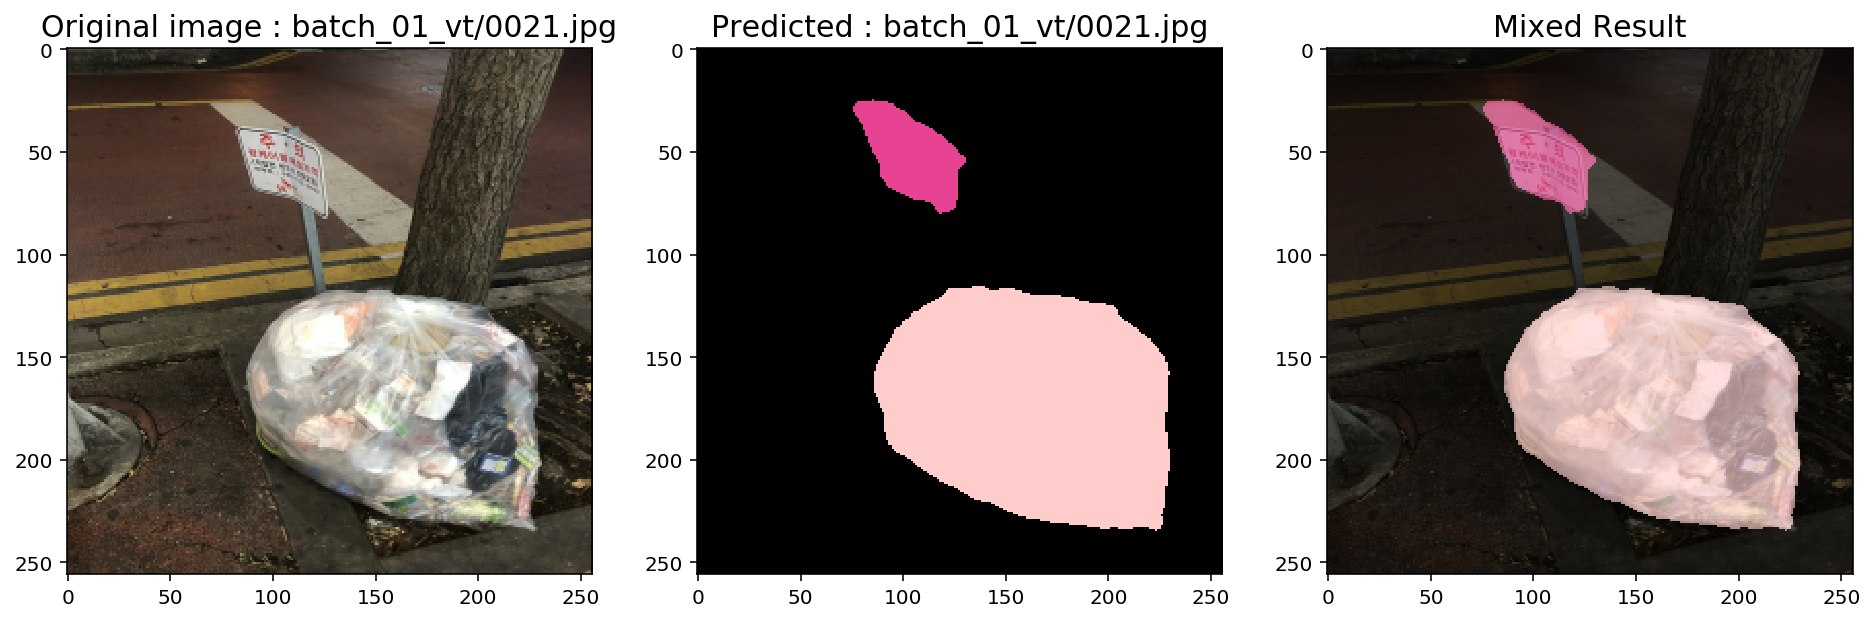

In [25]:
inference(COLORS, inv_norm)

In [ ]:
inference(COLORS, inv_norm, case=1)

In [ ]:
inference(COLORS, inv_norm, case=2)

# DenseCRF inference에 적용

In [54]:
def dense_crf_wrapper(args):
    return dense_crf(args[0], args[1])

def dense_crf(img, output_probs):
    MAX_ITER = 10
    POS_W = 3
    POS_XY_STD = 1
    Bi_W = 4
    Bi_XY_STD = 67
    Bi_RGB_STD = 3

    c = output_probs.shape[0]
    h = output_probs.shape[1]
    w = output_probs.shape[2]

    U = utils.unary_from_softmax(output_probs)
    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=POS_XY_STD, compat=POS_W)
    d.addPairwiseBilateral(sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img, compat=Bi_W)

    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    return Q

In [79]:
def inference_crf(is_crf=True):
    def collate_fn(batch):
        return tuple(zip(*batch))


    test_path = dataset_path + '/test.json'

    # training setting과 동일한 transform
    test_transform = A.Compose([
                            A.Normalize(),
                            A.Resize(256, 256),
                            ToTensorV2()
                            ])

    # test dataset
    test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=Cfg.batch_size,
                                            num_workers=4,
                                            collate_fn=collate_fn)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # model = FCN8s(num_classes=12)
    model = smp.DeepLabV3(encoder_name="efficientnet-b0",
            # encoder_depth=5,
            encoder_weights="imagenet",
            in_channels=3,
            classes=12,
            )
    model = model.to(device)

    model_path = os.path.join(Cfg.saved_dir, Cfg.file_name)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)

    print('Start prediction.')
    model.eval()

    with torch.no_grad():
        for step, (imgs, image_infos) in enumerate(tqdm(test_loader)):

            outs = model(torch.stack(imgs).float().to(device))
            
            if is_crf:
                probs = F.softmax(outs, dim=1).data.cpu().numpy()

                pool = mp.Pool(mp.cpu_count())
                images = torch.stack(imgs).data.cpu().numpy().astype(np.uint8).transpose(0, 2, 3, 1)
                probs = np.array(pool.map(dense_crf_wrapper, zip(images, probs)))
                pool.close()
                oms = np.argmax(probs, axis=1)
            else:
                oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()

            if step == 2:
                break

    print("End prediction.")
    idx = 1

    imgs = inv_norm(imgs[idx])

    org = np.stack(imgs)
    org = np.transpose(org, (1, 2, 0))
    mask = COLORS[oms[idx]]

    output = ((0.4 * (org * 255.)) + (0.6 * mask)).astype('uint8')

    print('Shape of Original Image :', list(imgs.shape))
    print('Shape of Predicted : ', list(oms.shape))
    print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(oms))])


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
    ax1.imshow(org)
    ax1.grid(False)
    ax1.set_title("Original image : {}".format(image_infos[idx]['file_name']), fontsize = 15)

    ax2.imshow(mask)
    ax2.grid(False)
    ax2.set_title("Predicted : {}".format(image_infos[idx]['file_name']), fontsize = 15)

    ax3.imshow(output)
    ax3.grid(False)
    ax3.set_title("Mixed Result", fontsize=15)

    plt.show()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


  0%|          | 0/210 [00:00<?, ?it/s]

Start prediction.


  1%|          | 2/210 [00:02<05:02,  1.45s/it]


End prediction.
Shape of Original Image : [3, 256, 256]
Shape of Predicted :  [4, 256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 2}, {'Paper', 3}, {9, 'Plastic bag'}]


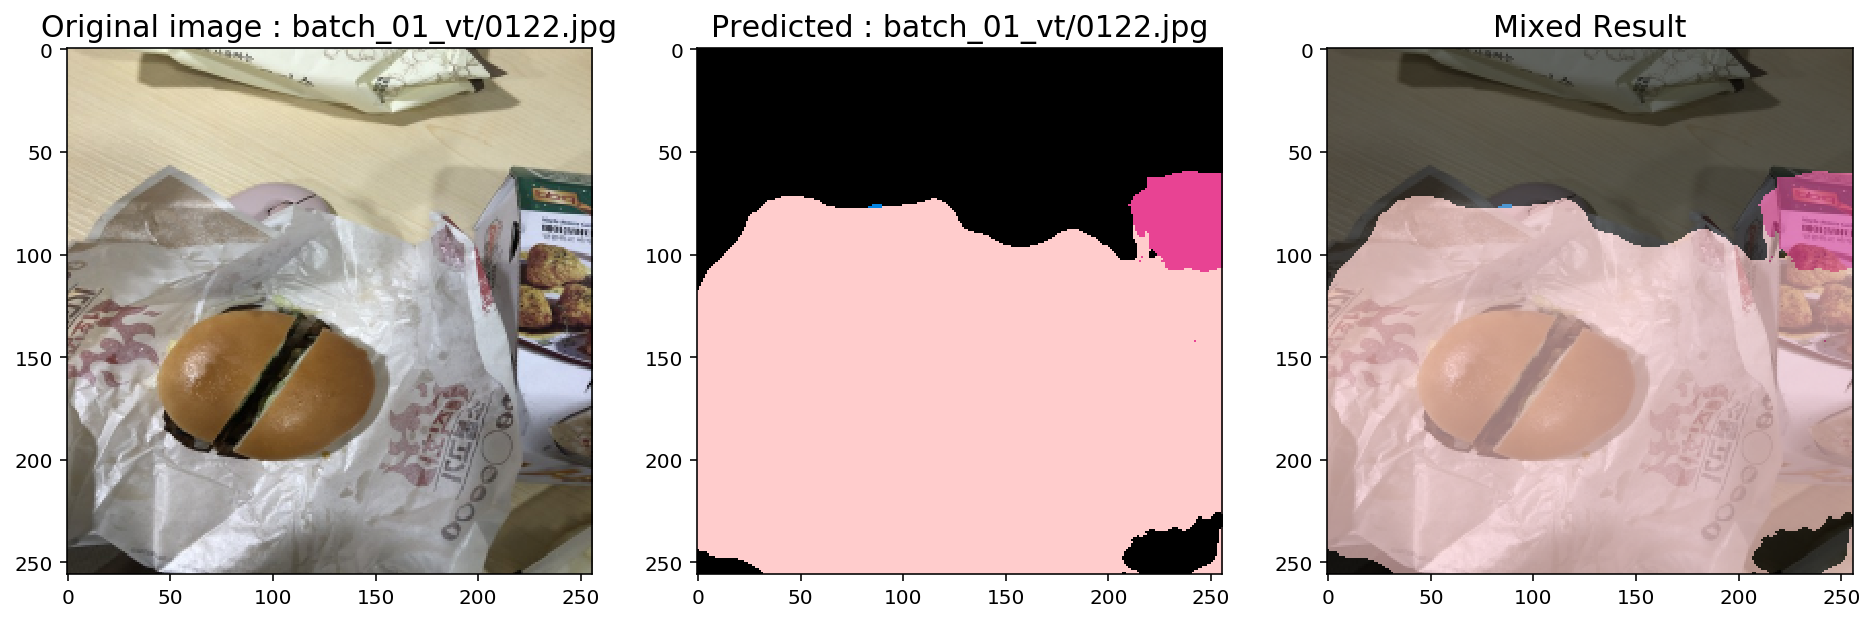

In [80]:
inference_crf()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


  0%|          | 0/210 [00:00<?, ?it/s]

Start prediction.


  1%|          | 2/210 [00:00<01:05,  3.19it/s]


End prediction.
Shape of Original Image : [3, 256, 256]
Shape of Predicted :  [4, 256, 256]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {'General trash', 2}, {'Paper', 3}, {'Metal', 5}, {'Plastic', 7}, {9, 'Plastic bag'}, {'Battery', 10}]


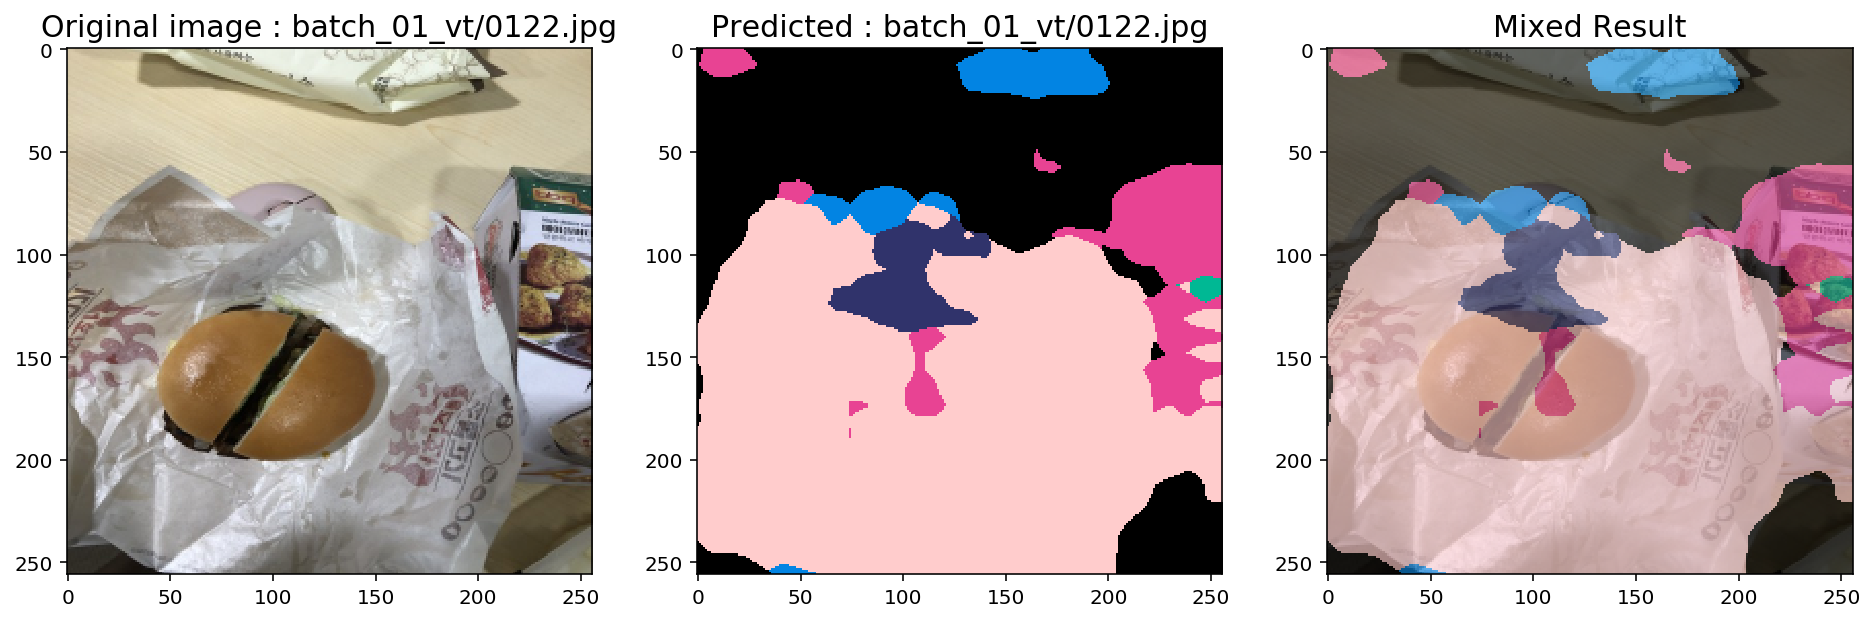

In [81]:
inference_crf(is_crf=False)